数据标准化（归一化）

In [ ]:
scaled_dataset = (dataset - dataset_mean) / dataset_std_deviation
train, test = split(scaled_dataset)

先用全体数据的均值和标准差标准化，然后再划分训练集和测试集。
这样会导致“数据泄漏”（data leakage），因为测试集的信息被用到了训练集的标准化参数中，模型评估结果会虚高。

In [ ]:
train, test = split(dataset)
scaled_train =  (train - train_mean) / train_std_deviation
scaled_test = (test - test_mean) / test_std_deviation

训练集和测试集分别用自己的均值和标准差做标准化。
这样虽然没有数据泄漏，但训练集和测试集的标准化方式不一致，导致模型在测试集上的表现不可靠，实际部署时也无法复现。

In [ ]:
scaled_train =  (train - train_mean) / train_std_deviation
scaled_test = (test - train_mean) / train_std_deviation

先划分训练集和测试集。
用训练集的均值和标准差对训练集和测试集都进行标准化。
这样既避免了数据泄漏，又保证了训练和测试的标准化方式一致，是机器学习中的标准做法。

# Evaluation

In [1]:
# Import Pandas and Numpy
import numpy as np
import pandas as pd

# Import Plotting Libraries
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Process the Chicago Crime Data

In [2]:
df = pd.read_csv("C:/Users/zhaoj/OneDrive - The University of Chicago/Desktop/uchicago/Q3/Machine Learning for public policy/ML_2021/data/chicago-crimes-2019.csv")
print("Found {} NaN community area records.".format(df['Community Area'].isna().sum()))
df.dropna(inplace=True)
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

Found 4 NaN community area records.


## Extract Features

In [3]:
df_backup = df.copy()
df = df.loc[:,['Hour', 'Community Area', 'Latitude', 'Longitude', 'Domestic', 'Arrest']]

labels = df.loc[:,'Hour':'Domestic'].columns.values
features = df.loc[:,'Hour':'Domestic'].values
target = df['Arrest'].values

## Random Forest Classifier

Random forest improves on a decision tree classifier using an ensemble learning method called bagging. In a random forest, 
1. many decision trees are trained. Each tree receives a boostrapped sample of observations, and 
2. each node only considers a subset of the features when determining the best split.

The `balanced` mode, which we use below, uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
n_samples / (n_classes * np.bincount(y)).

In [4]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, 
                            n_jobs=-1, 
                            n_estimators=100,
                            class_weight='balanced'
                           )
model = rf.fit(features,target)

### Evaluating the Random Forest Classifier

In [5]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.80, 
                                                    random_state=5) # 80% training and 20% test

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

# prediction on test set
y_pred=rf.predict(X_test)

#### Confusion Matrix

In [13]:
X = df.drop(columns=['Arrest'])
y = df['Arrest']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.20, 
                                                    random_state=5) # 80% training and 20% test

In [14]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

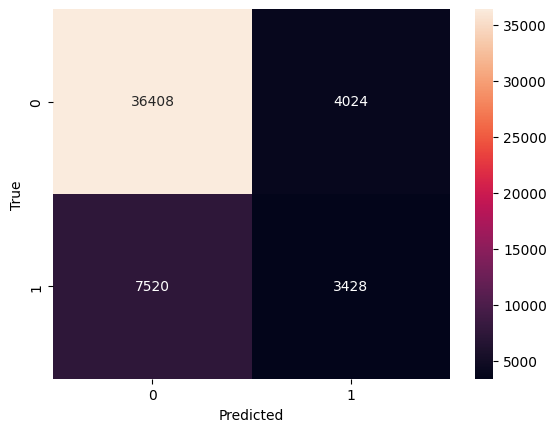

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Scoring

We can look at the following metrics:

* Accuracy: $\frac{TP + TN}{P + N}$ (total fraction of correct answers)


* Precision: $\frac{TP}{TP + FP}$ (fraction of positive detections that are correct)


* Recall (Detection Rate): $\frac{TP}{TP+FN}$ (fraction of positive classes correctly detected)


* F1 Score: $2 \cdot \frac{P\cdot R}{P + R}$

In [17]:
from sklearn import metrics

In [18]:
print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred)
                                                                          ))


Accuracy:	0.7753211366290386
Precision:	0.4600107353730542
Recall:		0.3131165509682134
F1 Score:	0.3726086956521739



In [19]:
print(metrics.classification_report(y_test, y_pred, target_names=['No Arrest', 'Arrest']))

              precision    recall  f1-score   support

   No Arrest       0.83      0.90      0.86     40432
      Arrest       0.46      0.31      0.37     10948

    accuracy                           0.78     51380
   macro avg       0.64      0.61      0.62     51380
weighted avg       0.75      0.78      0.76     51380



#### Receiver Operating Characteristic

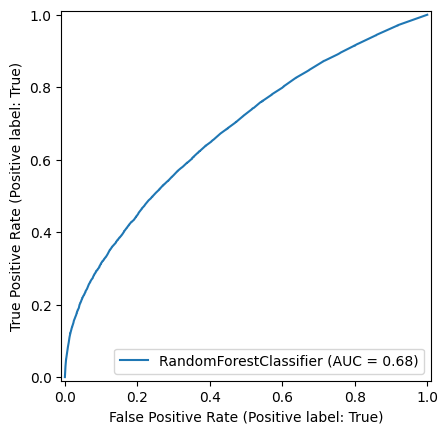

In [23]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

#### Precision-Recall Curve

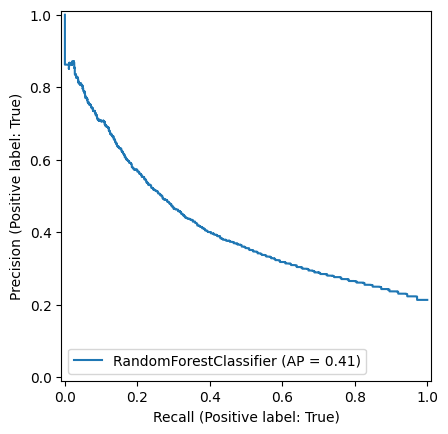

In [25]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test)
plt.show()

## Evaluation Function

In [26]:
def runEval(clf,X_test,y_test,y_pred,target_names=None):
    plot_confusion_matrix(clf,X_test,y_test)
    print(metrics.confusion_matrix(y_test, y_pred))
    print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred)
                                                                          ))
    plot_roc_curve(clf,X_test,y_test)
    plot_precision_recall_curve(clf,X_test,y_test)

## Evaluating Other Models

### Logistic Regression

In [27]:
df = df_backup

# Convert Arrest to int type
df['Arrest'] = df['Arrest'].astype(int)

# Number of Arrests per hour
arrest_hour = pd.DataFrame(df.groupby(['Hour'])['Arrest'] \
                                              .sum() \
                                              .reset_index(name='arrests') \
                                              .sort_values(['Hour'], ascending=True))

# Number of Incidents per hour
all_hour = pd.DataFrame(df.groupby(['Hour'])['ID'] \
                                              .count() \
                                              .reset_index(name='incidents') \
                                              .sort_values(['Hour'], ascending=True))

# New Dataframe
adf = pd.merge(arrest_hour,all_hour,on=['Hour'])
adf['prob'] = adf['arrests'] / adf['incidents']

# This is a derived binary variable that is "toy" for the sake of illustration.
adf['pthresh'] = adf['prob'] > 0.18
adf['hrs'] = (adf['Hour'] + 21) % 24

adf.head(5)

,Hour,arrests,incidents,prob,pthresh,hrs
0,0,2263,12335,0.183462,True,21
1,1,1768,7904,0.223684,True,22
2,2,1339,6891,0.194311,True,23
3,3,974,5457,0.178486,False,0
4,4,659,4391,0.150080,False,1


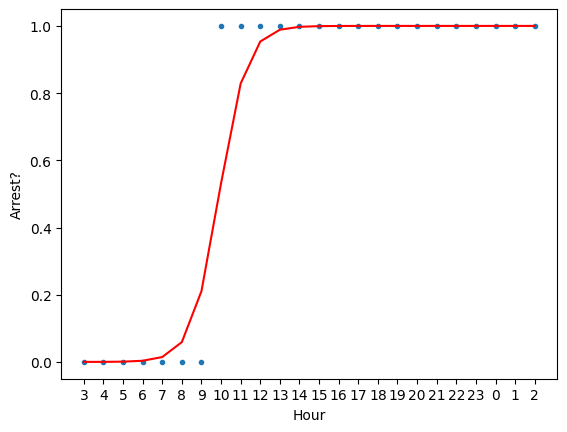

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Features for fitting the model.
x = adf['hrs'].astype('float').values.reshape(-1,1)
y = adf['pthresh']
z = np.arange(0.,24.,1).reshape(-1, 1);

penalty='l2'
C = 20
solver='lbfgs'

pipelineCV = Pipeline([
    ('norm', StandardScaler()),
    ('logr', LogisticRegressionCV(penalty=penalty,
                                  class_weight='balanced',
                                  Cs=C,
                                  cv=2,
                                  random_state=0,
                                  solver=solver)),
])


pipelineCV.fit(x,y)
lineCV = pipelineCV.predict_proba(z)[:,1]

hours = pd.concat([adf['Hour'][3:], adf['Hour'][0:3]])
plt.xticks(np.arange(24),hours)
plt.xlabel('Hour')
plt.ylabel('Arrest?')
plt.plot(x,y,'.')
plt.plot(z, lineCV, color='red')
plt.show()

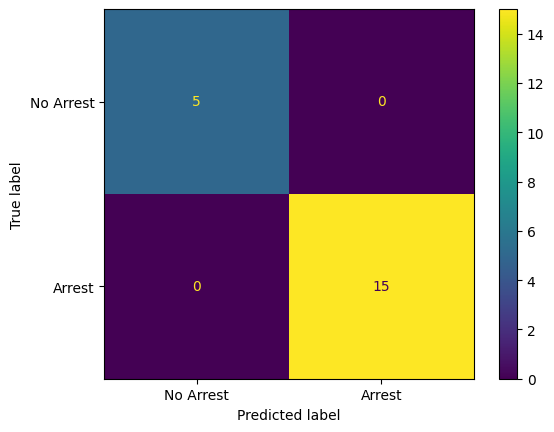

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Arrest', 'Arrest'])
disp.plot()
plt.show()

### Support Vector Machines

In [34]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline

df = df_backup
features = df.loc[:,['Primary Type', 'Domestic', 'Community Area','Location Description','Hour']]
features2d = df.loc[:,['Community Area', 'Hour']]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features2d, 
                                                    target, 
                                                    test_size=0.80, 
                                                    random_state=5) # 80% training and 20% test

In [35]:
svc = Pipeline([
    ('ohe', OneHotEncoder()),
    ('svc', SVC(kernel='linear', random_state=0, gamma=0.5, C=1.0, class_weight='balanced')),
])

In [36]:
# Train the model using the training sets y_pred=clf.predict(X_test)
svc.fit(X_train,y_train)

# prediction on test set
y_pred = svc.predict(X_test)

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def runEval(clf, X_test, y_test, y_pred, target_names=None):
    # 混淆矩阵可视化
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=target_names)
    plt.show()

    print(confusion_matrix(y_test, y_pred))

    print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ))

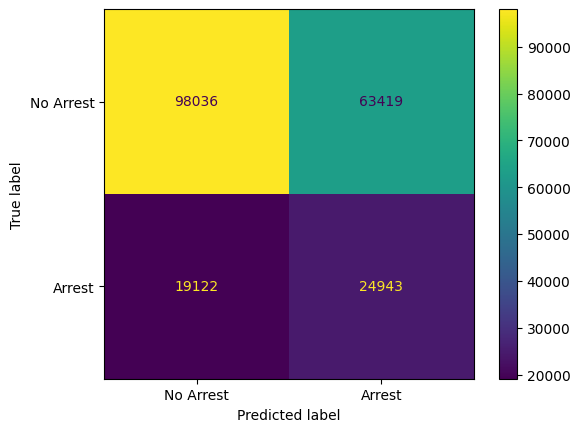

[[98036 63419]
 [19122 24943]]
Accuracy:	0.5983797197353056
Precision:	0.2822819764152011
Recall:		0.5660501531827982
F1 Score:	0.37670565670142797



In [40]:
runEval(svc, X_test, y_test, y_pred, ['No Arrest', 'Arrest'])